In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, Latex
from models import MatrixGenerator
from utils.data_management import check_constraints
from models import DictionaryLearning
from models import model_selection
from models.gaussian_model import GaussianCopula


import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# One-Factor - Gaussian Copula model 


Consider
\begin{align*}
X^t_{i}=\rho Z^t+\sqrt{1-\rho^2} \epsilon^t_i,\\ \text{with } Z^t=\kappa Z^{t-1} + \epsilon^z_{t}
\end{align*}

with the speed of mean reversion $\kappa$ and the noise $\epsilon_t^z\sim\mathcal N(0,1)$. 
We take $\kappa=\exp(-\frac{\log 2}{10})=0.93$, coming from the half-life $H=-\frac{\log 2}{\log |\kappa|}$ of the AR(1) process, considering that the PIT matrices are
issued quarterly with an economic cycle of 5 years.


The matrix $P^t$ are generated through
\begin{align*}
P_{ij}^t:=\Phi\left(\frac{\rho Z^t+\Phi^{-1}(P^{TTC}_{i,\geq j})}{\sqrt{1-\rho^2}}\right)
- \Phi\left(\frac{\rho Z^t+\Phi^{-1}(P^{TTC}_{i,\geq j+1})}{\sqrt{1-\rho^2}}\right)
\end{align*}


In [2]:
N_MAT = 100  # number of matrices : value of T
R_DIM = 11  # Dim of the matrix [R-1]x[R]

mm_model = MatrixGenerator(n_mat=N_MAT, r_dim=R_DIM)

## Matrix $P^{TTC} \in \mathbb{R}^{10\times 11}$
\begin{align}
P^{TTC} = \mathrm{norm_r}\left(\begin{bmatrix} 
    2(R-i) & \frac{(R-j)}{(1+j-i)}(\frac{i}{j}) & \dots \\
    \frac{(R-i)}{(1+i-j)}(\frac{j}{i}) & \ddots & \ddots & \\
    \vdots &   \ddots    &  \ddots
    \end{bmatrix}\right)
\end{align}
with $i\in \{0,\ldots,R-2\}$, $j\in \{0,\ldots,R-1\}$ and $\mathrm{norm_r}$ is the normalization by row

In [3]:
mm_model.show_ttc()

<IPython.core.display.Latex object>

,0,1,2,3,4,5,6,7,8,9,10
0,0.715,0.179,0.054,0.024,0.013,0.007,0.004,0.003,0.001,0.001,0.000
1,0.160,0.576,0.144,0.057,0.028,0.015,0.009,0.005,0.003,0.002,0.001
2,0.050,0.151,0.538,0.135,0.059,0.030,0.017,0.010,0.005,0.003,0.001
3,0.024,0.065,0.147,0.514,0.128,0.059,0.031,0.017,0.009,0.005,0.002
4,0.014,0.036,0.072,0.145,0.496,0.124,0.057,0.030,0.015,0.008,0.003
5,0.010,0.023,0.043,0.077,0.145,0.482,0.120,0.055,0.027,0.013,0.005
6,0.007,0.016,0.029,0.049,0.082,0.147,0.470,0.117,0.051,0.023,0.008
7,0.005,0.012,0.022,0.035,0.054,0.087,0.152,0.457,0.114,0.045,0.015
8,0.005,0.010,0.018,0.027,0.041,0.061,0.096,0.164,0.437,0.109,0.033
9,0.004,0.009,0.016,0.024,0.036,0.051,0.075,0.114,0.192,0.383,0.096


In [4]:
pttc = mm_model.mat_ttc
df_ttc = pd.DataFrame(pttc, columns=[np.arange(1,12)], index=[np.arange(1,11)])*100
df_ttc.round(2)

,1,2,3,4,5,6,7,8,9,10,11
1,71.48,17.87,5.36,2.38,1.25,0.71,0.43,0.26,0.15,0.08,0.03
2,16.01,57.62,14.41,5.69,2.80,1.54,0.89,0.52,0.30,0.16,0.06
3,5.05,15.14,53.85,13.46,5.89,3.03,1.68,0.96,0.54,0.28,0.11
4,2.45,6.52,14.67,51.35,12.84,5.87,3.06,1.68,0.92,0.47,0.18
5,1.45,3.61,7.23,14.46,49.57,12.39,5.74,2.95,1.55,0.76,0.30
6,0.96,2.31,4.34,7.71,14.46,48.19,12.05,5.51,2.71,1.29,0.48
7,0.70,1.63,2.94,4.90,8.16,14.69,47.00,11.75,5.14,2.28,0.82
8,0.54,1.24,2.18,3.48,5.44,8.71,15.24,45.71,11.43,4.51,1.52
9,0.45,1.02,1.75,2.73,4.09,6.14,9.55,16.38,43.67,10.92,3.28
10,0.43,0.95,1.60,2.43,3.55,5.11,7.46,11.36,19.17,38.35,9.59


## Generate matrix $P^{t} \in \mathbb{R}^{10\times 11}$

In [5]:
mm_model.fit()  # fit PIT matrices
#mm_model.show_pit()  # show all PIT matrices

In [6]:
mm_model.show_mat_pit()

<IPython.core.display.Latex object>

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.791987,0.744252,0.739381,0.742732,0.763762,0.729730,0.645685,0.645902,0.608965,0.497792,...,0.874556,0.925921,0.912606,0.942132,0.946879,0.953893,0.936806,0.913989,0.891888,0.905676
1,0.161094,0.126312,0.120079,0.124519,0.139195,0.116784,0.076119,0.075118,0.062543,0.035757,...,0.254810,0.359395,0.328317,0.406027,0.423983,0.453317,0.393344,0.330632,0.285371,0.315042
2,0.041968,0.029996,0.027807,0.028741,0.033148,0.026314,0.014788,0.014374,0.011491,0.005368,...,0.079887,0.135505,0.118816,0.164827,0.174520,0.192492,0.153617,0.119240,0.093397,0.109199
3,0.017177,0.011749,0.010923,0.011298,0.013488,0.010222,0.005259,0.005287,0.003928,0.001684,...,0.037230,0.069237,0.058690,0.087705,0.093575,0.105799,0.080533,0.058477,0.045022,0.053842
4,0.009149,0.005971,0.005478,0.005790,0.006893,0.005188,0.002568,0.002467,0.001854,0.000741,...,0.021355,0.041889,0.034659,0.053866,0.058650,0.068304,0.050081,0.035000,0.026153,0.031824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.000807,0.001349,0.001525,0.001426,0.001142,0.001620,0.003399,0.003446,0.004518,0.009867,...,0.000252,0.000079,0.000109,0.000047,0.000040,0.000029,0.000056,0.000108,0.000178,0.000130
106,0.001678,0.002761,0.002958,0.002799,0.002318,0.003209,0.006426,0.006509,0.008436,0.017508,...,0.000560,0.000183,0.000250,0.000115,0.000098,0.000073,0.000134,0.000248,0.000401,0.000298
107,0.003890,0.006081,0.006659,0.006271,0.005248,0.006974,0.013335,0.013424,0.017222,0.032933,...,0.001407,0.000502,0.000665,0.000322,0.000273,0.000210,0.000368,0.000660,0.001044,0.000780
108,0.011082,0.016483,0.017899,0.016809,0.014452,0.018479,0.032234,0.032802,0.040265,0.070661,...,0.004419,0.001751,0.002294,0.001180,0.001025,0.000805,0.001341,0.002269,0.003397,0.002649


In [7]:
P = mm_model.full_mat_pit
#N_MAT = P.shape[1]
#n_test = int(0.2 * N_MAT)
#P_test = P[:, -int(n_test):]
#n_train = int(N_MAT-n_test)
#P_train = P[:, :int(N_MAT-n_test)]

In [8]:
check_constraints(data=P)

(200, 110)
Inequality constraints unsatisfied: 0 (0.00%)
Equality constraints unsatisfied: 0 (0.00%)


# $Z$ series

In [9]:
len(mm_model.list_eco_series)

101

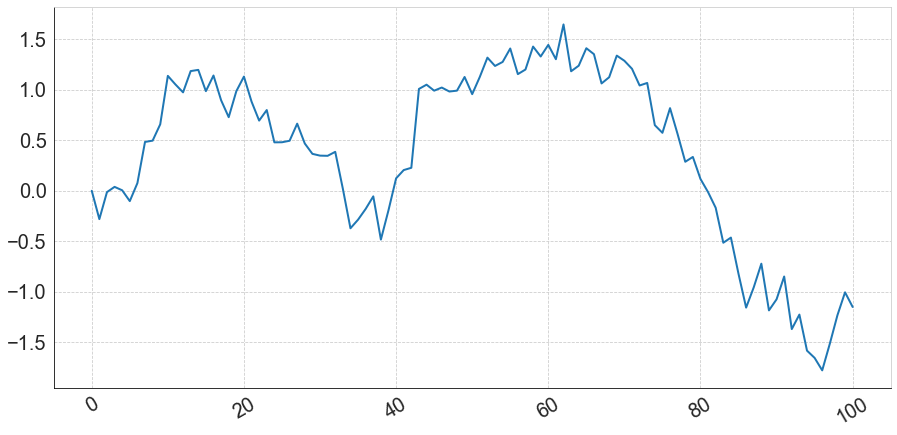

In [15]:
# Series of Zt
fig, ax = plt.subplots(1, 1, figsize=(15,7),)
ax.plot(np.arange(len(mm_model.list_eco_series)), 
            mm_model.list_eco_series, 
            linewidth=2)
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")
_=plt.xticks(fontsize=20, rotation=30)
_=plt.yticks(fontsize=20)

#plt.savefig("imgs/gaussian_copula/Zseries_synth.eps", format="eps")

# Dictionary Learning

In [18]:
for lamb in [1]:
    model_DL = DictionaryLearning(K=2, r_dim=11)
    model_DL.fit(P, lamb=lamb, max_iter=500)
    reconstruction_DL = np.sqrt((np.linalg.norm(P - model_DL.D @ model_DL.A) ** 2) / N_MAT)
    print("The DL (K=2, lamb={}) reconstruction RMSE is {:.6f}".format(lamb, reconstruction_DL))

The DL (K=2, lamb=1) reconstruction RMSE is 0.124766


# Gaussian Copula Model

In [11]:
model_GC = GaussianCopula()
model_GC.fit(P)
reconstruction_GC = np.sqrt((np.linalg.norm(P - model_GC.P_GC) ** 2) / N_MAT)
print("The DL reconstruction RMSE is {:.6f}".format(reconstruction_GC))

The DL reconstruction RMSE is 0.116041


In [12]:
model_GC.alpha1, model_GC.alpha2

(array([-0.40306076, -0.24820219, -0.21793372, -0.23755724, -0.29952322,
        -0.19631668,  0.03985728,  0.04628162,  0.13978047,  0.4180813 ,
         0.36801677,  0.32314875,  0.44508764,  0.4523824 ,  0.33029362,
         0.41942762,  0.27842509,  0.18107808,  0.32905752,  0.41389454,
         0.27058634,  0.16186334,  0.22151714,  0.03639135,  0.03754138,
         0.04647746,  0.1439527 ,  0.03015849, -0.02929528, -0.03946652,
        -0.04045792, -0.01727739, -0.22838032, -0.45475071, -0.4055052 ,
        -0.34403815, -0.27239157, -0.51840553, -0.35192382, -0.16933233,
        -0.12143935, -0.10910604,  0.34260109,  0.36711735,  0.33324903,
         0.35026794,  0.32810694,  0.33291215,  0.41086404,  0.31325109,
         0.41112163,  0.5210725 ,  0.47350382,  0.49720691,  0.57363013,
         0.42703737,  0.45340917,  0.58478308,  0.52881347,  0.59507254,
         0.5124471 ,  0.71222113,  0.4439833 ,  0.47519907,  0.57577336,
         0.5412355 ,  0.37378753,  0.40973396,  0.5

$$\alpha_2 \approx 1/\sqrt{1-\rho^2}$$

In [13]:
# Theoretical \alpha_2
1/np.sqrt(1-mm_model.rho**2)

1.1547005383792517